In [1]:
import numpy as np
import pandas as pd
import re
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import STL
from IPython import display
from datetime import datetime
from collections import defaultdict
import json
%matplotlib inline

# Methods

In [2]:
# Check for nulls
def check_nulls(features):
    print("\n\u001b[1mChecking Nulls:\u001b[0m")
    null_percentage = (features.isnull().sum() / features.shape[0]) * 100
    null_percentage = null_percentage[null_percentage > 0].reset_index()
    null_percentage.columns = ['Feature', 'Null_Percentage']
    if not null_percentage.empty:
        print(null_percentage.to_string(index=False))
    else:
        print("No features with null values.")
#df overview
def overview(df):
    print("\n\u001b[1mOverview:\u001b[0m")
    rows = df.shape[0]
    col = df.shape[1]
    print('The dataframe has',(rows),'rows and',(col),'columns')

# Question 1

In [ ]:
#Calendar File
calendar = pd.read_csv('C:/Users/elena.zampieri.SUMUP/Desktop/Udacity - Project 1/archive/calendar.csv')
overview(calendar)
calendar_rows = calendar.shape[0]
min_date = calendar['date'].min()
max_date = calendar['date'].max()
price_nan = calendar['price'].isnull().sum()/calendar.shape[0]
print('The first date is',min_date, 'and the last date is',max_date)
print("There are ",calendar['listing_id'].nunique(),"unique listings and 365 days")
check_nulls(calendar)

In [ ]:
#Prepare the dataframe
calendar_clean = calendar.dropna(subset=['price'])
calendar_clean.head()
calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
calendar_clean['price'] = calendar_clean['price'].apply(extract_price_number)
calendar_clean.info()
print(calendar_clean['date'].max())
print(calendar_clean['date'].min())

In [ ]:
# Group by Day
calendar_clean_grouped = calendar_clean.groupby(['date']).agg({'price': ['mean', 'median']})
calendar_clean_grouped.reset_index(drop=False, inplace=True)

# Create a line plot
plt.figure(figsize=(8, 5))

# Plot the mean price variation
plt.plot(calendar_clean_grouped['date'], calendar_clean_grouped[('price', 'mean')])

# Set the chart title and labels
plt.title('Mean Price Variation')
plt.xlabel('Date')
plt.ylabel('Mean Price')


# Show the plot
plt.show()

In [ ]:
# Checking Listing by Neighborhood
neighborhood_counts = listing['neighbourhood_cleansed'].value_counts()

# Calculate the percentage of total houses in each neighborhood
neighborhood_percentages = (neighborhood_counts / len(listing))*100

# Plotting the bar chart
plt.figure(figsize=(8, 5))
neighborhood_percentages.plot(kind='bar')
plt.title('Percentage of Total Houses by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.ylim(0,10)  # Set the y-axis limits
plt.tight_layout()
plt.show()

In [ ]:
# Merging with listing df to get neighborhood information
merged_calendar_listing = pd.merge(calendar_clean[['listing_id', 'date', 'available','price']],
                        listing[['id','neighbourhood_cleansed']],
                        left_on='listing_id',
                        right_on='id',
                        how='left')
merged_calendar_listing = merged_calendar_listing[['listing_id', 'date', 'available','price','neighbourhood_cleansed']]
neighborhoods_of_interest = ['Jamaica Plain', 'South End', 'Back Bay', 'Fenway', 'Dorchester','Allston','Beacon Hill']
merged_calendar_listing = merged_calendar_listing[merged_calendar_listing['neighbourhood_cleansed'].isin(neighborhoods_of_interest)]
merged_calendar_listing.head()

# Grouping by day
merged_calendar_listing_grouped = merged_calendar_listing.groupby(['date', 'neighbourhood_cleansed']).agg({'price': ['mean', 'median']})
merged_calendar_listing_grouped.head()

# Reset the index of the grouped DataFrame
merged_calendar_listing_grouped.reset_index(drop=False, inplace=True)

# Create a line plot
plt.figure(figsize=(8, 5))

# Iterate over each neighborhood
for neighborhood, data in merged_calendar_listing_grouped.groupby('neighbourhood_cleansed'):
    # Plot the mean price variation
    plt.plot(data['date'], data['price']['mean'], label=neighborhood)

# Set the chart title and labels
plt.title('Mean Price Variation by Neighborhood')
plt.xlabel('Date')
plt.ylabel('Mean Price')

# Add a legend
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))

# Show the plot
plt.show()

# Question 2

In [ ]:
#Question 3
def total_count(df, col1, col2, look_for):
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

possible_vals = ["TV", '"Cable TV"','"Wireless Internet"','"Air Conditioning"',"Kitchen","Heating","Washer","Dryer", 
                 "Internet","Gym",'"Elevator in Building"','"Buzzer/Wireless Intercom"',"Heating",'"Family/Kid Friendly"',
                 '"Smoke Detector"','"Carbon Monoxide Detector"',"Essentials","Shampoo",'"24-Hour Check-in"',"Hangers",'"Hair Dryer"',
                 "Iron",'"Laptop Friendly Workspace"','"Fire Extinguisher"','"Wheelchair Accessible"','"Pets Allowed"',"Doorman",
                 '"Indoor Fireplace"','"Suitable for Events"']

In [ ]:
def clean_and_plot(df, title='Amenities', plot=True):
    amenities = listing['amenities'].value_counts().reset_index()
    amenities.rename(columns={'index': 'amenities', 'amenities': 'count'}, inplace=True)
    amenities_df = total_count(amenities, 'amenities', 'count', possible_vals)
    amenities_df['amenities'] = amenities_df['amenities'].apply(lambda x: x.strip('"'))
    amenities_df.set_index('amenities', inplace=True)
    if plot:
        (amenities_df/amenities_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_amenities_df = amenities_df/amenities_df.sum()
    return props_amenities_df
    
props_df = clean_and_plot(listing)

# Question 3

In [3]:
#Opening Listing File
listing = pd.read_csv('C:/Users/elena.zampieri.SUMUP/Desktop/Udacity - Project 1/archive/listings.csv')
listing.head()
overview(listing)
check_nulls(listing)


Overview:
The dataframe has 3585 rows and 95 columns

Checking Nulls:
                     Feature  Null_Percentage
                     summary         3.988842
                       space        29.483961
       neighborhood_overview        39.470014
                       notes        55.090656
                     transit        35.983264
                      access        41.534170
                 interaction        43.347280
                 house_rules        33.249651
               thumbnail_url        16.708508
                  medium_url        16.708508
              xl_picture_url        16.708508
               host_location         0.306834
                  host_about        36.513250
          host_response_time        13.138075
          host_response_rate        13.138075
        host_acceptance_rate        13.138075
          host_neighbourhood         9.456067
               neighbourhood        15.146444
neighbourhood_group_cleansed       100.000000
         

In [4]:
#Transform Variable Type
listing['host_since'] = pd.to_datetime(listing['host_since'])

#Fill Nulls in Property Types
listing['property_type'] = listing['property_type'].fillna(listing['property_type'].mode()[0])

#Transform Price Column
def extract_price_number(price_string):
    if isinstance(price_string, str):
        return float(re.sub(r"[^\d.]", "", price_string))
    else:
        return float('nan')

listing[['price','cleaning_fee','security_deposit']] = listing[['price','cleaning_fee','security_deposit']].applymap(extract_price_number)

#Create X matrix with the features and Y matrix with value we want to predict
listing_y = listing['price']
listing_x = listing[['id','host_is_superhost','host_since','neighbourhood_cleansed','bathrooms','property_type','bedrooms','beds','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','is_location_exact','cancellation_policy','room_type','accommodates','guests_included', 'minimum_nights','maximum_nights','instant_bookable']]#,'availability_30', 'availability_60', 'availability_90','availability_365','number_of_reviews']]

#Fill Numeric Nulls with Mean
listing_num_vars = listing_x.select_dtypes(include=['float', 'int']).columns

for col in listing_num_vars:
    listing_x[col].fillna((listing_x[col].mean()), inplace=True)
        
#Dummy Variables
listing_cat_vars = listing_x.select_dtypes(include=['object']).copy().columns
print(listing_cat_vars)

for var in listing_cat_vars:
    # for each cat add dummy var, drop original column
    listing_x = pd.concat([listing_x.drop(var, axis=1), pd.get_dummies(listing_x[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

#Date into numeric Variable
today = datetime.now()
listing_x['days_as_host'] = (today - listing_x['host_since']).dt.days
listing_x = listing_x.drop('host_since', axis=1)
 
#Renaming Columns
listing_x = listing_x.rename(columns={'host_is_superhost_t': 'host_is_superhost', 
                                      'neighbourhood_cleansed_Back Bay': 'back_bay_neighbourhood',
                                      'neighbourhood_cleansed_Bay Village': 'bay_village_neighbourhood',
                                      'neighbourhood_cleansed_Beacon Hill': 'beacon_hill_neighbourhood',
                                      'neighbourhood_cleansed_Brighton': 'brighton_neighbourhood',
                                      'neighbourhood_cleansed_Charlestown': 'charlestown_neighbourhood',
                                      'neighbourhood_cleansed_Chinatown': 'chinatown_neighbourhood',
                                      'neighbourhood_cleansed_Dorchester': 'dorchester_neighbourhood',
                                      'neighbourhood_cleansed_Mission Hill': 'mission_hill_neighbourhood',
                                      'neighbourhood_cleansed_North End': 'north_end_neighbourhood',
                                      'neighbourhood_cleansed_Roslindale': 'roslindale_neighbourhood',
                                      'neighbourhood_cleansed_Roxbury': 'roxbury_neighbourhood',
                                      'neighbourhood_cleansed_South Boston': 'south_boston_neighbourhood',
                                      'neighbourhood_cleansed_South Boston Waterfront': 'south_boston_waterfront_neighbourhood',
                                      'neighbourhood_cleansed_South End': 'south_end_neighbourhood',
                                      'neighbourhood_cleansed_West End': 'west_end_neighbourhood',
                                      'neighbourhood_cleansed_West Roxbury': 'west_roxbury_neighbourhood',
                                      'neighbourhood_cleansed_Downtown':'downtown_neighbourhood',
                                      'neighbourhood_cleansed_East Boston':'east_boston_neighbourhood',
                                      'neighbourhood_cleansed_Fenway':'fenway_neighbourhood',
                                      'neighbourhood_cleansed_Hyde Park':'hyde_park_neighbourhood',
                                      'neighbourhood_cleansed_Jamaica Plain':'jamaica_plain_neighbourhood',
                                      'neighbourhood_cleansed_Leather District':'leather_district_neighbourhood',
                                      'neighbourhood_cleansed_Longwood Medical Area':'longwood_medical_area',
                                      'neighbourhood_cleansed_Mattapan':'mattapan_neighbourhood',
                                      'property_type_Bed & Breakfast': 'property_type_bed_breakfast', 
                                      'property_type_Boat': 'property_type_boat',
                                      'property_type_Camper/RV':'property_type_camper', 
                                      'property_type_Condominium':'property_type_condominium',
                                      'property_type_Dorm':'property_type_dorm', 
                                      'property_type_Entire Floor':'property_type_entire_floor',
                                      'property_type_Guesthouse':'property_type_guesthouse', 
                                      'property_type_House':'property_type_house', 
                                      'property_type_Loft':'property_type_loft',
                                      'property_type_Other':'property_type_other', 
                                      'property_type_Townhouse':'property_type_townhouse', 
                                      'property_type_Villa':'property_type_villa',
                                      'is_location_exact_t':'is_location_exact',
                                      'room_type_Private room':'room_type_private_room',
                                      'room_type_Shared room':'room_type_shared_room',
                                      'instant_bookable_t':'instant_bookable'})

check_nulls(listing_x)


Index(['host_is_superhost', 'neighbourhood_cleansed', 'property_type',
       'is_location_exact', 'cancellation_policy', 'room_type',
       'instant_bookable'],
      dtype='object')

Checking Nulls:
No features with null values.


C:\Users\elena.zampieri.SUMUP\AppData\Local\Temp\ipykernel_12784\1161024291.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listing_x[col].fillna((listing_x[col].mean()), inplace=True)


In [5]:
#def clean_fit_linear_mod(df_feature,df_response, test_size=.3, rand_state=42):
# Split into test and train variable
listing_x_train, listing_x_test, listing_y_train, listing_y_test = train_test_split(listing_x, listing_y, test_size=.3, random_state=133)

# Instantiate
lm_model = LinearRegression() 

# Fit
lm_model.fit(listing_x_train, listing_y_train) 

#Predict using your model
listing_y_test_preds = lm_model.predict(listing_x_test)
listing_y_train_preds = lm_model.predict(listing_x_train)

#Score using your model
listing_test_score = r2_score(listing_y_test, listing_y_test_preds)
listing_train_score = r2_score(listing_y_train, listing_y_train_preds)

print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(listing_train_score, listing_test_score))
    
#return listing_test_score, listing_train_score, lm_model, listing_x_train, listing_x_test, listing_y_train, listing_y_test

#Test your function with the above dataset
#listing_test_score, listing_train_score, lm_model, listing_x_train, listing_x_test, listing_y_train, listing_y_test = clean_fit_linear_mod(listing_x,listing_y)

The rsquared on the training data was 0.4338446042345394.  The rsquared on the test data was 0.20657136565051537.


In [6]:
# Get coeficients by feature
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, listing_x_train)

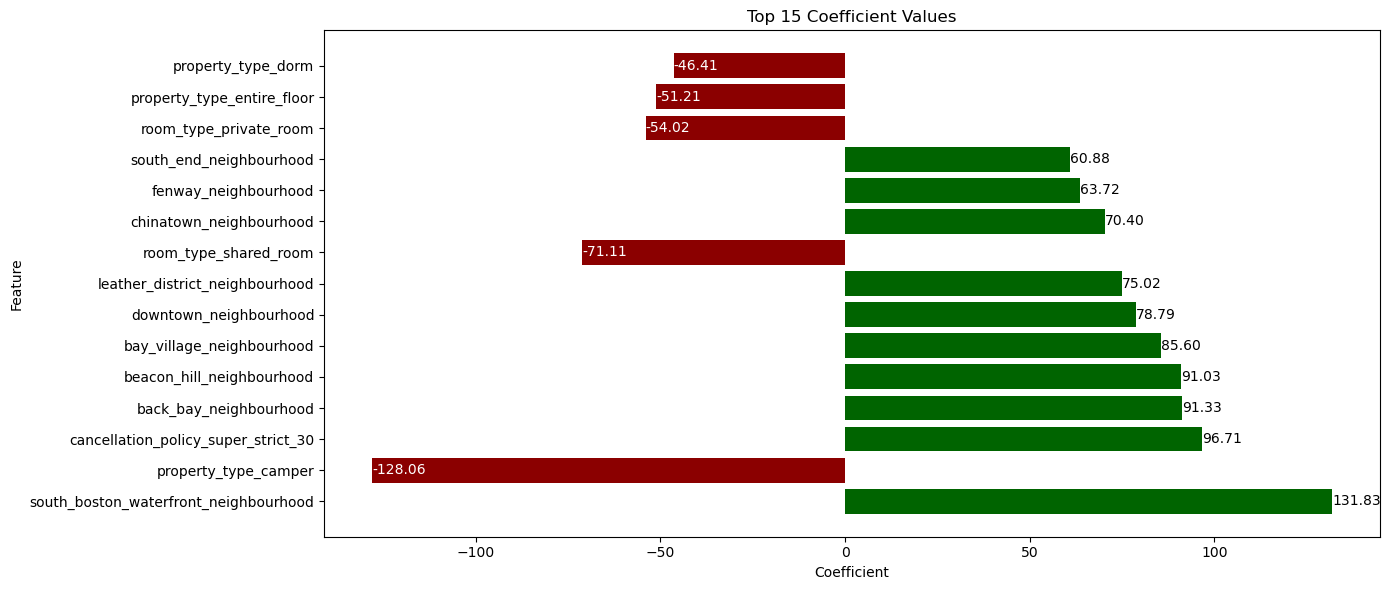

In [7]:
coef_df.sort_values(by='abs_coefs', ascending=False, inplace=True)

# Select the top 15 highest absolute coefficient values
top_15_df = coef_df.head(15)

# Set color based on positive and negative values
colors = ['darkred' if coef < 0 else 'darkgreen' for coef in top_15_df['coefs']]

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
plt.barh(top_15_df['est_int'], top_15_df['coefs'], color=colors)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 15 Coefficient Values')
plt.tight_layout()

# Add number labels on each bar
for i, (coef, color) in enumerate(zip(top_15_df['coefs'], colors)):
    plt.text(coef, i, f'{coef:.2f}', va='center', color='white' if color == 'darkred' else 'black')

plt.show()